# ENHANCED K-MEANS WITH AUTO-ENCODERS

IMPORT PACKAGES

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import warnings
from pylab import rcParams
from math import sqrt, floor


Bad key "text.kerning_factor" on line 4 in
C:\Users\illav\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


IMPORT DEEP LEARNING PACKAGES

In [2]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


NAIVE-SHARDING CENTRAL INITIALIZATION

In [3]:
def naive_sharding(ds, k):
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))
    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids
def _get_mean(sums, step):
    return sums/step

CREATE DATASET

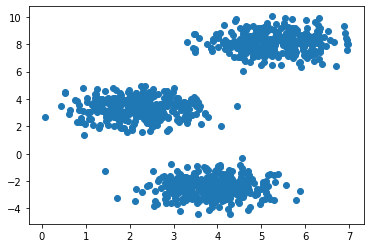

In [4]:
features, target = make_blobs(n_samples = 1000,
                  n_features = 2,
                  centers = 3,
                  cluster_std = 0.72,
                  shuffle = True)
df=pd.DataFrame(features)
df.columns = ['x1', 'x2']
plt.scatter(df['x1'],df['x2'])
plt.show()

Centroids using naive sharding (scaled data)
--------------------------------------------
[[ 2.06873326 -2.42520036]
 [ 3.83948344  3.31327567]
 [ 5.38787528  8.17498541]]


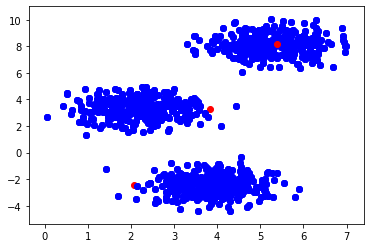

In [5]:
import numpy
import sklearn.preprocessing
from sklearn.datasets import load_iris
X = features
y = target
# Use naive sharding to generate initial centroids
k=3
centroids_scaled = naive_sharding(df, 3)
print ('Centroids using naive sharding (scaled data)')
print ('--------------------------------------------')
print(centroids_scaled)
l=0
j=0
i=0
a=[]

for l in range(k):
  for j in range(2):
    a.append(centroids_scaled[l,j])
for i in range(0,2*k,2):
  #print(a[i])
  plt.scatter(df['x1'],df['x2'],c='b')
  plt.scatter(a[i],a[i+1],c='r')

COMPARING TIME DIFFERENCE

WITHOUT NAIVE SHARDING:

In [ ]:
from datetime import datetime
dist_points_from_cluster_center1=[]
K=range(1,10)
startTime = datetime.now()
for k in K:
    k_model=KMeans(n_clusters=k)
    k_model.fit(df)
    dist_points_from_cluster_center1.append(k_model.inertia_)
print("time elapsed without naive-sharding",datetime.now() - startTime)

WTIH NAIVE SHARDING

In [6]:
from datetime import datetime
dist_points_from_cluster_center=[]
K=range(1,10)
startTime1 = datetime.now()
for k in K:
    cluster_centroids=[]
    cluster_centroids=naive_sharding(df, k)
    k_model=KMeans(n_clusters=k,init=cluster_centroids,n_init=1)
    k_model.fit(df)
    dist_points_from_cluster_center.append(k_model.inertia_)
print("time elapsed with naive-sharding",datetime.now() - startTime1)

time elapsed with naive-sharding 0:00:06.991309


ELBOW METHOD

Text(0.5, 1.0, 'Elbow curve')

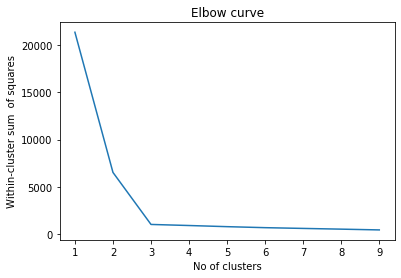

In [7]:
plt.plot(K,dist_points_from_cluster_center)
plt.ylabel('Within-cluster sum  of squares')
plt.xlabel('No of clusters')
plt.title('Elbow curve')

ENHANCED ELBOW METHOD

Text(0.5, 1.0, 'Enhanced Elbow curve')

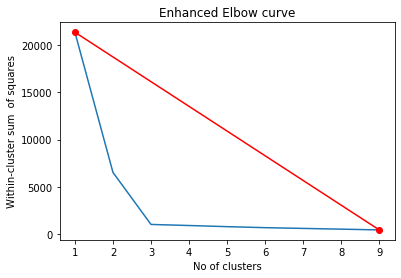

In [8]:
plt.plot(K,dist_points_from_cluster_center)
plt.plot([K[0],K[8]],[dist_points_from_cluster_center[0],dist_points_from_cluster_center[8]],'ro-')
plt.ylabel('Within-cluster sum  of squares')
plt.xlabel('No of clusters')
plt.title('Enhanced Elbow curve')

In [9]:
def calc_distance(x1,y1,a,b,c):
  d=abs((a*x1+b*y1+c))/(math.sqrt(a*a+b*b))
  return d
a=dist_points_from_cluster_center[0]-dist_points_from_cluster_center[8]
b=K[8]-K[0]
c1=K[0]*dist_points_from_cluster_center[8]
c2=K[8]*dist_points_from_cluster_center[0]
c=c1-c2
distance_of_points_from_line=[]
for k in range(9):
  distance_of_points_from_line.append(
      calc_distance(K[k],dist_points_from_cluster_center[k],a,b,c))


Text(0.5, 0, 'No of clusters')

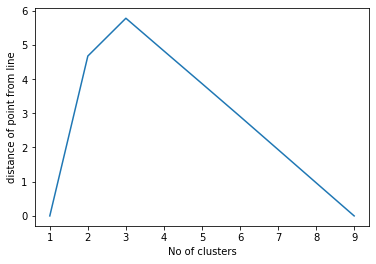

In [10]:
plt.plot(K,distance_of_points_from_line)
plt.ylabel('distance of point from line')
plt.xlabel('No of clusters')

OPTIUM VALUE FOR K

In [11]:
opt_k= str(distance_of_points_from_line.index(max(distance_of_points_from_line))+1)
print("Optimal value of k:"+opt_k)   

Optimal value of k:3


In [16]:
opt_k=int(opt_k)
cluster_centroids=naive_sharding(df, opt_k)
k_model=KMeans(n_clusters=opt_k,init=cluster_centroids,n_init=1)
k_model.fit(df)
y_kmeans = k_model.predict(df)

In [33]:
from sklearn.metrics import silhouette_score 
silhouette_avg = silhouette_score(df,y_kmeans)
print(" no of clusters =", opt_k, 
          " ,The average silhouette_score is :", silhouette_avg) 


 no of clusters = 3  ,The average silhouette_score is : 0.7773549949016032


In [18]:
opt_k=int(opt_k)
startTime = datetime.now()
cluster_centroids=naive_sharding(df, opt_k)
k_model=KMeans(n_clusters=opt_k,init=cluster_centroids,n_init=1)
k_model.fit(df)
y_kmeans = k_model.predict(df)
print("time elapsed",datetime.now() - startTime)
print("no of iterations:",k_model.n_iter_)

time elapsed 0:00:00.265291
no of iterations: 2


KMEANS FOR OPTIUM VALUE K

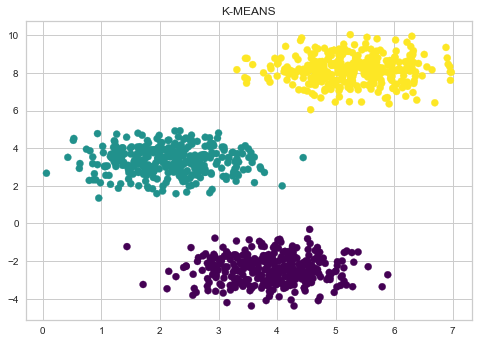

In [51]:
plt.scatter(df['x1'], df['x2'], c=y_kmeans, s=50, cmap='viridis')
plt.title('K-MEANS')
centers = k_model.cluster_centers_

In [20]:
df['Cluster']=k_model.labels_
df.head()

,x1,x2,Cluster
0,4.021623,-1.307344,0
1,2.248432,3.785096,1
2,4.065751,-0.990552,0
3,5.448010,9.224108,2
4,2.874729,-1.871845,0


TRAIN-TEST SPLIT

In [21]:
RANDOM_SEED = 101
scaler = MinMaxScaler()
Kcluster=[]
Clust=[]
for i in range(opt_k):
    Kcluster.append(df[df.Cluster == i])
    Clust.append(scaler.fit_transform(Kcluster[i]))

In [22]:
train_Clust=[]
test_Clust=[]
for i in range(opt_k):
    X_train, X_test = train_test_split(Clust[i], test_size=0.2, random_state = RANDOM_SEED)
    train_Clust.append(X_train)
    test_Clust.append(X_test)

HYPER PARAMETERS FOR DEEP LEARNING

In [23]:
encoding_dim = 6
hidden_dim = int(encoding_dim / 2)
nb_epoch = 30
batch_size = 128
learning_rate = 0.1

AUTO-ENCODER DEEP-LEARNING

In [24]:
def Auto_encoder(df):
    input_dim = df.shape[1]
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation='relu')(encoder)
    decoder = Dense(encoding_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='tanh')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

OUTLIER DETECTION

In [25]:
predictions=[]
predictions_test=[]
mse=[]
mse_test=[]
mse_threshold=[]
autoencoder=[]
for i in range(opt_k):
    autoencoder.append(Auto_encoder(train_Clust[i]))
    predictions.append(autoencoder[i].predict(Clust[i]))
    predictions_test.append(autoencoder[i].predict(test_Clust[i]))
    mse.append(np.mean(np.power(Clust[i] - predictions[i], 2), axis=1))
    mse_test.append(np.mean(np.power(test_Clust[i] - predictions_test[i], 2), axis=1))
    mse_threshold.append(np.quantile(mse_test[i], 0.95))
    Kcluster[i]['MSE']=mse[i]
    print(f'MSE 0.925 threshhold:{mse_threshold[i]}')

MSE 0.925 threshhold:0.3083889169795553
MSE 0.925 threshhold:0.447193206896967
MSE 0.925 threshhold:0.36228447652389256


C:\Users\illav\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
for i in range(opt_k):
    Kcluster[i]['MSE_Outlier']=0
    Kcluster[i].loc[Kcluster[i]['MSE'] > mse_threshold[i], 'MSE_Outlier'] = 1
    print(f"Num of MSE outlier:{Kcluster[i]['MSE_Outlier'].sum()}")

Num of MSE outlier:29
Num of MSE outlier:24
Num of MSE outlier:22


C:\Users\illav\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\illav\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


K-MEANS POST FILTER 

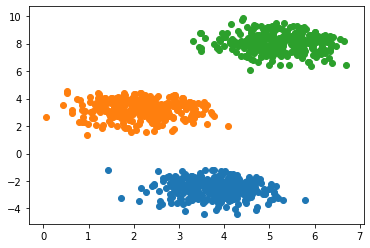

In [27]:
Kcluster_filt=[]
for i in range(opt_k):
    Kcluster_filt.append(Kcluster[i][(Kcluster[i]['MSE'] < mse_threshold[i])])
    plt.scatter( Kcluster_filt[i]['x1'],Kcluster_filt[i]['x2'])
plt.show()

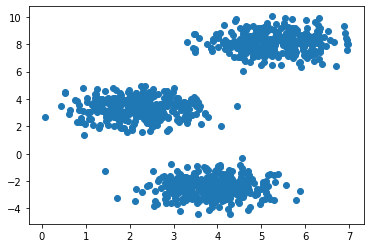

In [28]:
plt.scatter(df['x1'],df['x2'])
plt.show()

Text(0.5, 1.0, 'POST OUTLIER DETECTION')

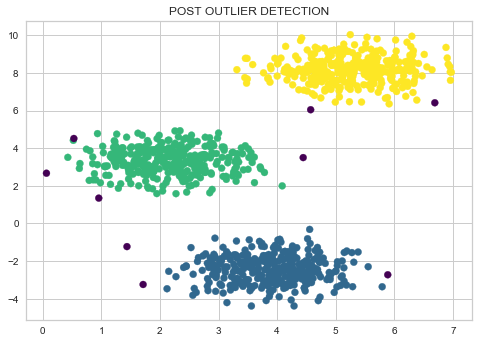

In [52]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.59, min_samples=9).fit(df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
y_pred = db.fit_predict(df)
plt.scatter(df['x1'],df['x2'],c=y_pred, cmap='viridis')
plt.title("POST OUTLIER DETECTION")

In [31]:
df_filt=np.concatenate((Kcluster_filt[0],Kcluster_filt[1],Kcluster_filt[2]))

In [34]:
from sklearn.metrics import silhouette_score
cluster_centroids=naive_sharding(df_filt, opt_k)
cluster = KMeans(n_clusters = opt_k,init=cluster_centroids,n_init=1) 
cluster_labels = cluster.fit_predict(df_filt) 
silhouette_avg = silhouette_score(df_filt,cluster_labels)
print(" no of clusters =", opt_k, 
          " ,The average silhouette_score is :", silhouette_avg)

 no of clusters = 3  ,The average silhouette_score is : 0.7908626565292021


In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score
 
    sil_avg = silhouette_score(df, cluster)
    print &quot;For number of clusters: &quot; + str(num_cluster) + &quot; average sil score:&quot; + str(sil_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster)

Automatically created module for IPython interactive environment
For n_clusters = 3 The average silhouette_score is : 0.7908626565292021


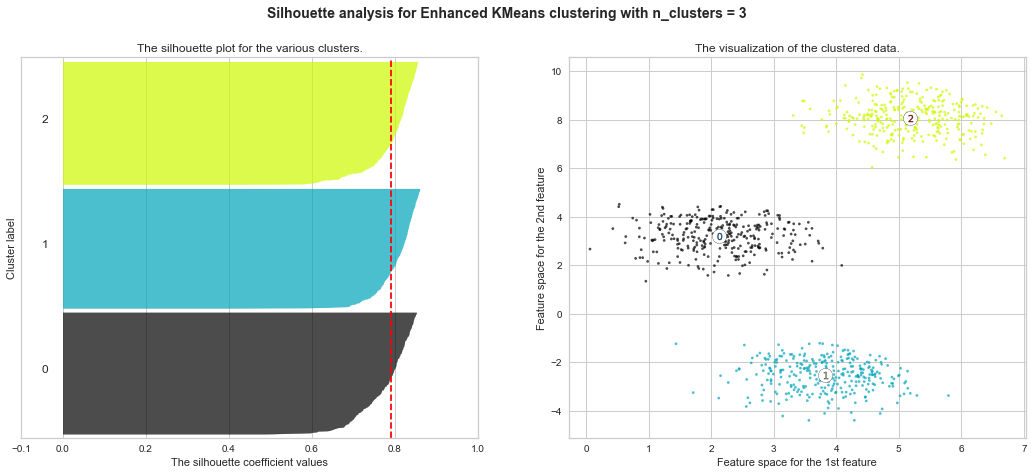

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
range_n_clusters=[3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_filt) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_filt)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_filt, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_filt, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_filt[:, 0], df_filt[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Enhanced KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()